Using device: cuda

===== Step 1: Loading Training Data =====
Total images found in /kaggle/input/brain-tumor-mri-dataset/Training: 2916
Loading batch 1-500 out of 2916
Loading batch 501-1000 out of 2916
Loading batch 1001-1500 out of 2916
Loading batch 1501-2000 out of 2916
Loading batch 2001-2500 out of 2916
Loading batch 2501-2916 out of 2916
Data loading complete. Total samples: 2916
Class distribution: No Tumor: 1595, Glioma: 1321

===== Step 2: Loading Validation Data (from Testing folder) =====
Total images found in /kaggle/input/brain-tumor-mri-dataset/Testing: 705
Loading batch 1-500 out of 705
Loading batch 501-705 out of 705
Data loading complete. Total samples: 705
Class distribution: No Tumor: 405, Glioma: 300

===== Step 3: Creating Binary Classification Model =====
BrainTumorModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1)

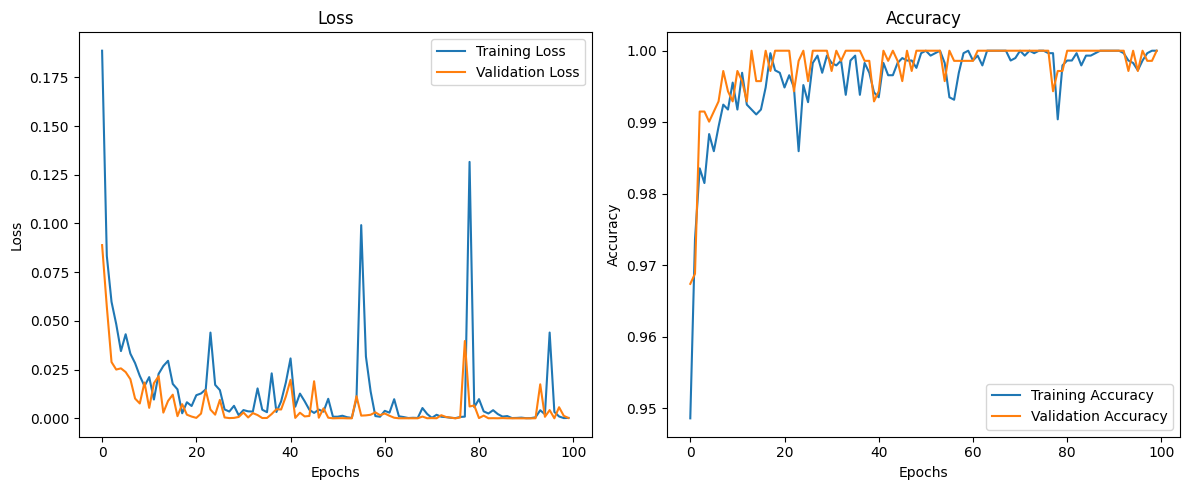


===== SHAP Explanations =====
Creating DeepExplainer with 50 background samples


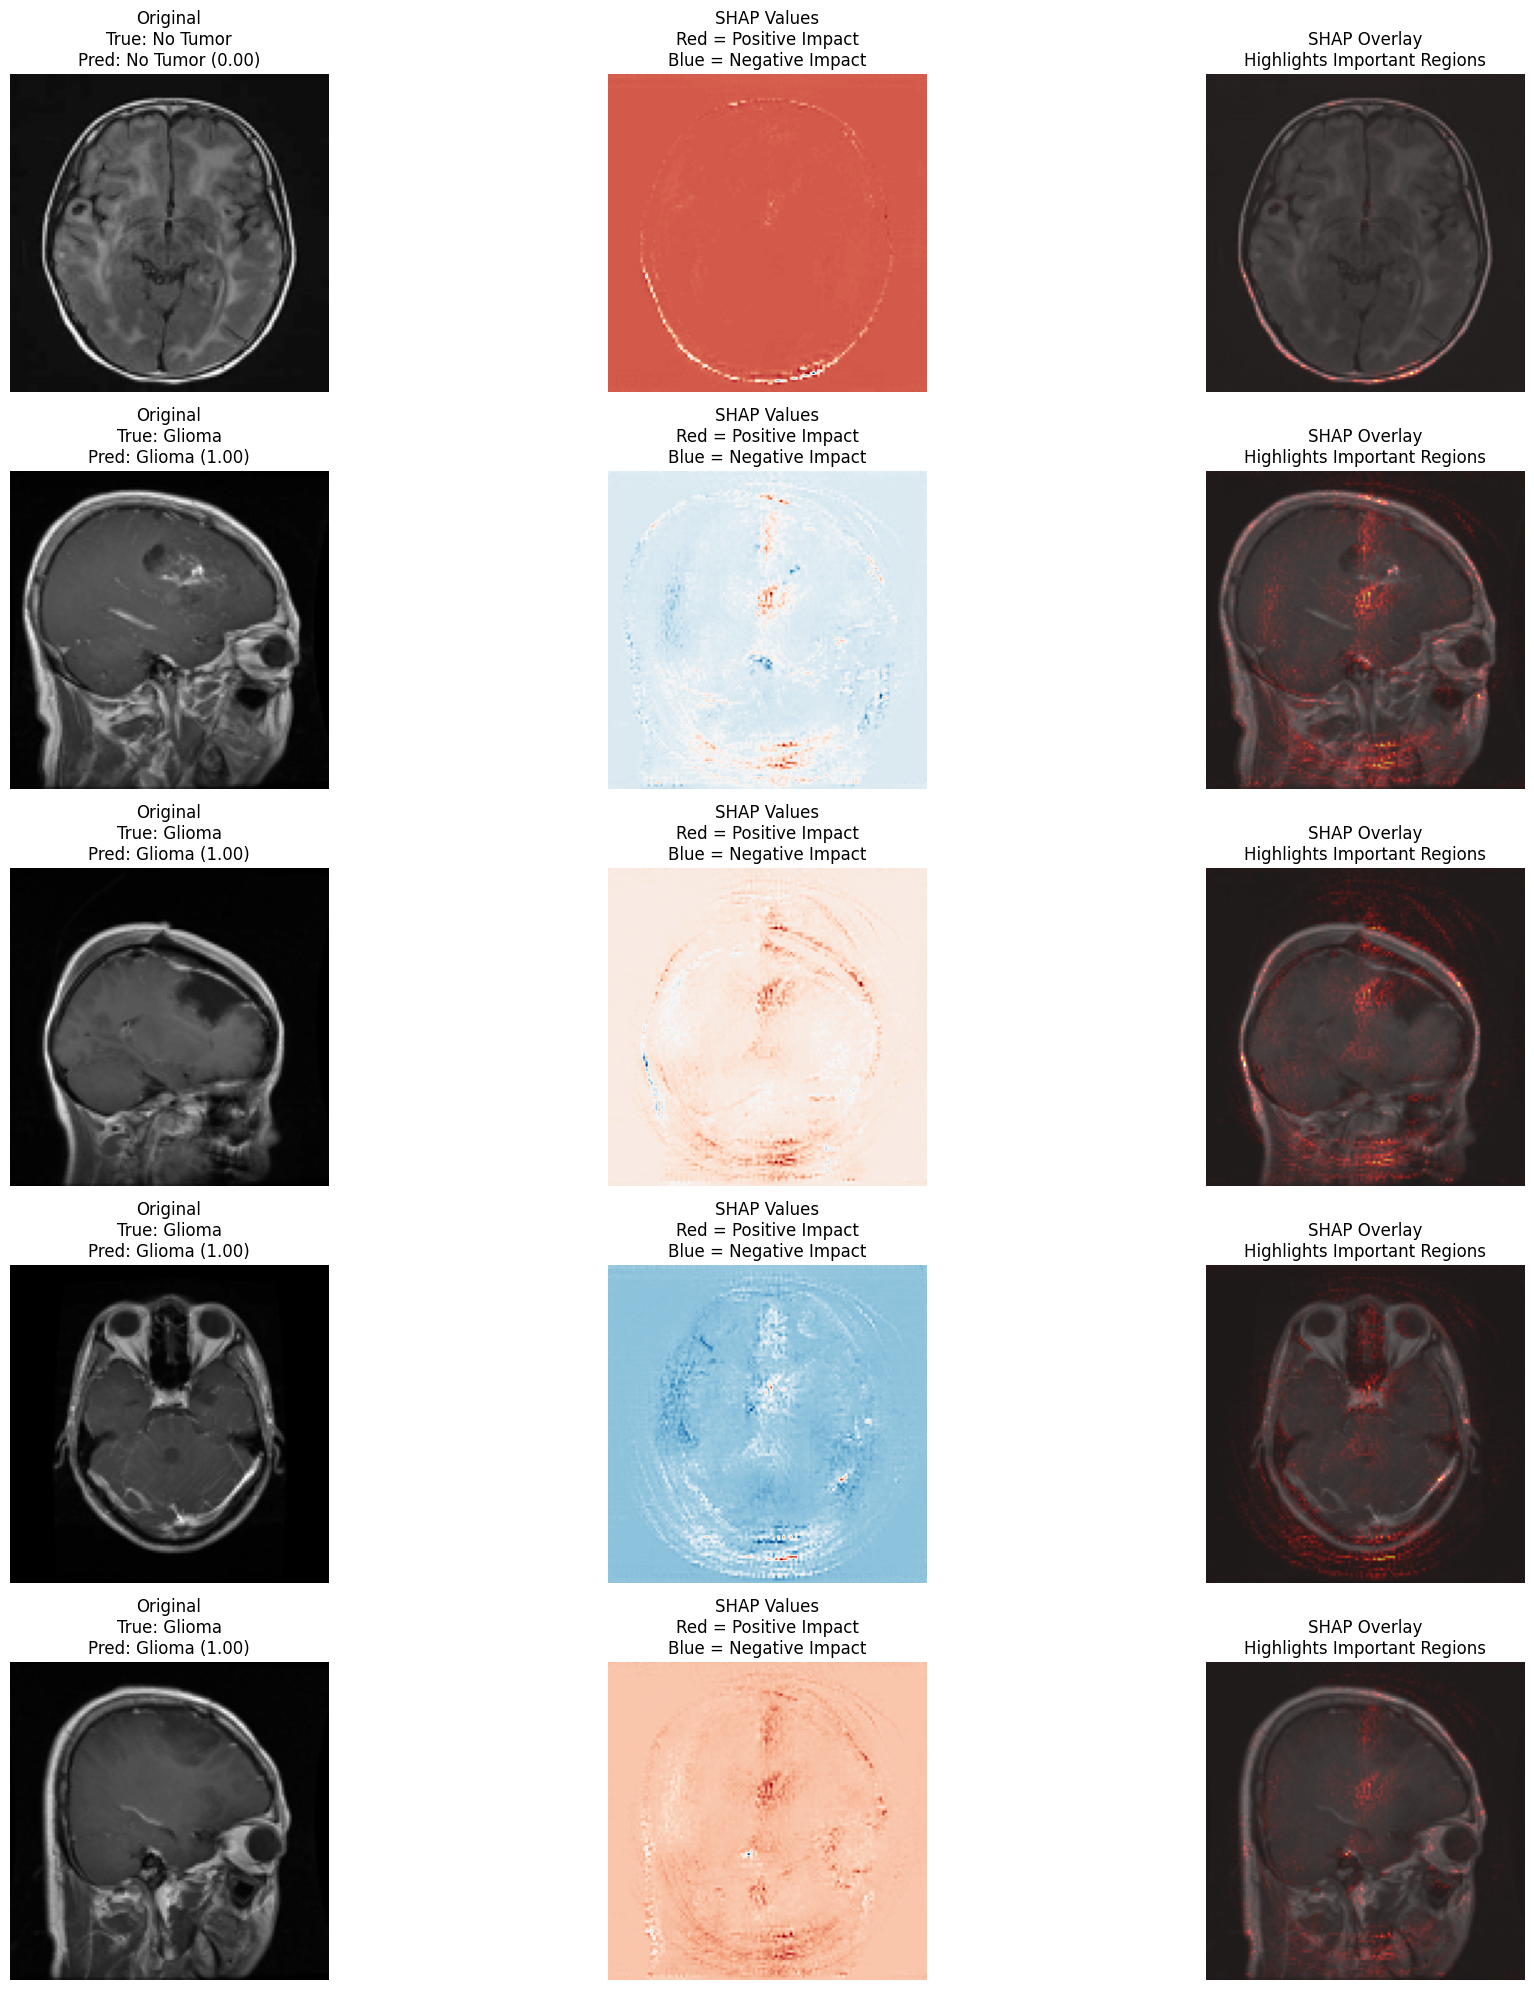


===== SHAP Summary Plot =====
Creating DeepExplainer with 50 background samples


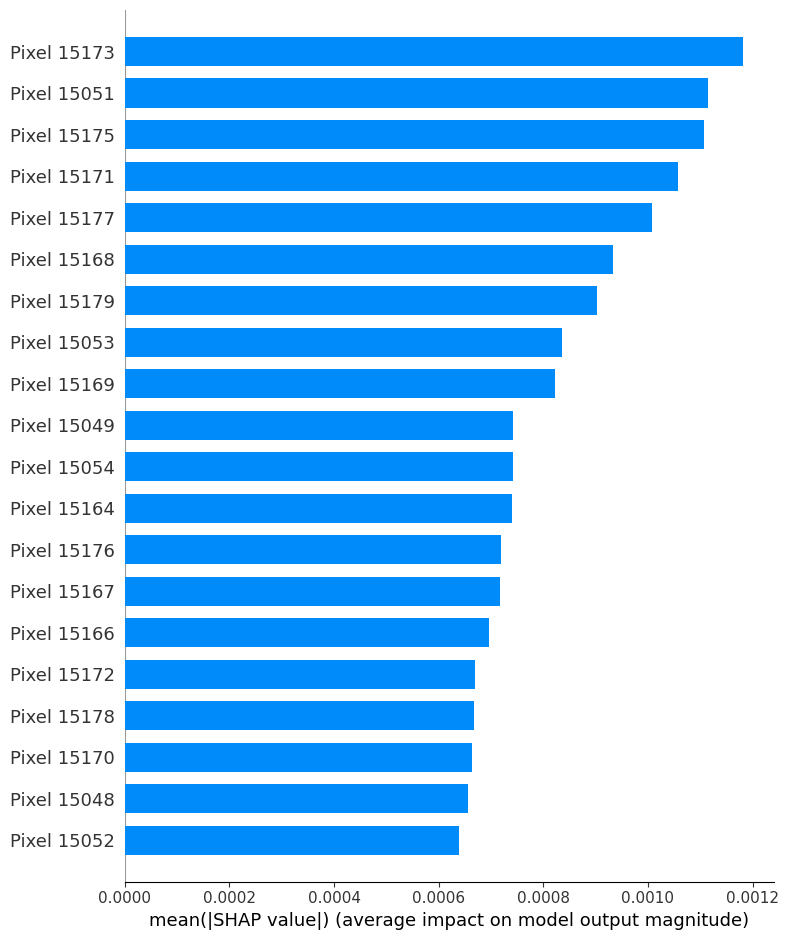


===== SHAP Analysis by Class =====
Creating DeepExplainer with 50 background samples


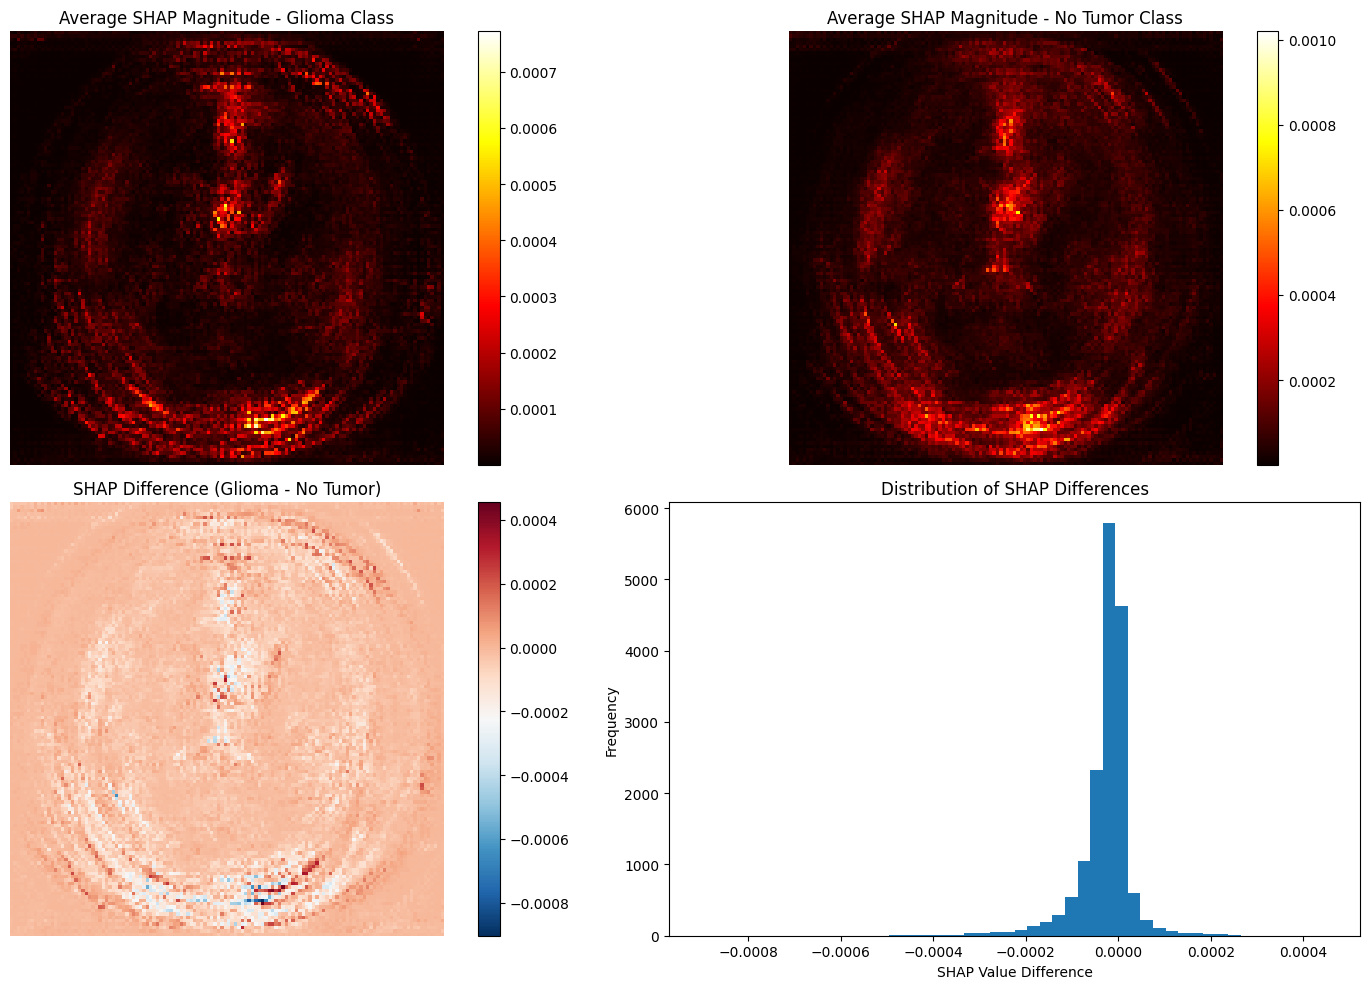

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc
import shap

# Verify GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Custom Dataset class for brain tumor images
class BrainTumorDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert numpy array to PIL Image
        image = Image.fromarray(image.squeeze().astype(np.uint8))

        if self.transform:
            image = self.transform(image)

        return image, label

# Function to load image data from a directory (without splitting)
def load_image_data(data_dir, image_size=128, batch_size=500, verbose=True):
    """
    Load image data from directories for binary classification (glioma vs no tumor).
    Returns data without train/test splitting.
    """
    all_images = []
    all_labels = []
    class_counts = {0: 0, 1: 0}

    # Create lists of file paths for each class
    glioma_dir = os.path.join(data_dir, 'glioma')
    notumor_dir = os.path.join(data_dir, 'notumor')
    
    if not os.path.exists(glioma_dir) or not os.path.exists(notumor_dir):
        print(f"Error: Could not find required subdirectories in {data_dir}")
        return None, None
    
    glioma_images = [os.path.join(glioma_dir, f) for f in os.listdir(glioma_dir)
                    if f.endswith(('.jpg', '.png', '.jpeg'))]
    notumor_images = [os.path.join(notumor_dir, f) for f in os.listdir(notumor_dir)
                     if f.endswith(('.jpg', '.png', '.jpeg'))]

    all_files = glioma_images + notumor_images
    total_images = len(all_files)
    print(f"Total images found in {data_dir}: {total_images}")

    if total_images == 0:
        print(f"No image files found in {data_dir}.")
        return None, None

    for batch_start in range(0, total_images, batch_size):
        batch_end = min(batch_start + batch_size, total_images)

        if verbose:
            print(f"Loading batch {batch_start+1}-{batch_end} out of {total_images}")

        batch_images = []
        batch_labels = []

        for i in range(batch_start, batch_end):
            try:
                file_path = all_files[i]

                # Load image using PIL
                img = Image.open(file_path).convert('L')  # Convert to grayscale
                img = img.resize((image_size, image_size))
                img_array = np.array(img)
                img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension

                # Determine label based on file path
                label = 1 if 'glioma' in file_path else 0

                batch_images.append(img_array)
                batch_labels.append(label)
                class_counts[label] += 1

            except Exception as e:
                print(f"Error processing file {i} ({file_path}): {str(e)}")

        all_images.extend(batch_images)
        all_labels.extend(batch_labels)
        gc.collect()

    # Convert to numpy arrays
    X = np.array(all_images)
    y = np.array(all_labels).astype(np.float32)

    if verbose:
        print(f"Data loading complete. Total samples: {len(X)}")
        print(f"Class distribution: No Tumor: {class_counts[0]}, Glioma: {class_counts[1]}")

    del all_images, all_labels
    gc.collect()

    return X, y

# PyTorch CNN model for binary classification
class BrainTumorModel(nn.Module):
    def __init__(self):
        super(BrainTumorModel, self).__init__()

        # Simpler architecture to make SHAP analysis more efficient
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        # Calculate the flattened size based on input dimensions
        # For 128x128 input, after 3 pooling layers: 16x16x64
        self.fc1 = nn.Linear(16 * 16 * 64, 64)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu4(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)

        return x

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=3):
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().view(-1, 1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).float().view(-1, 1)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)

        print(f'Epoch {epoch+1}/{epochs} | '
              f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | '
              f'Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}')

    return history

# Main function to run the entire pipeline with Training folder for training and Testing folder for validation
def run_brain_tumor_classification(train_dir, test_dir, image_size=128, batch_size=16, epochs=3):
    print("\n===== Step 1: Loading Training Data =====")
    X_train, y_train = load_image_data(train_dir, image_size=image_size)
    
    print("\n===== Step 2: Loading Validation Data (from Testing folder) =====")
    X_val, y_val = load_image_data(test_dir, image_size=image_size)

    if X_train is None or X_val is None:
        print("Error loading data. Please check the dataset paths.")
        return None, None, None, None, None, None, None, None

    # Define transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Create datasets
    train_dataset = BrainTumorDataset(X_train, y_train, transform=transform)
    val_dataset = BrainTumorDataset(X_val, y_val, transform=transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    print("\n===== Step 3: Creating Binary Classification Model =====")
    model = BrainTumorModel().to(device)
    print(model)

    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print("\n===== Step 4: Training Binary Classification Model with Validation =====")
    history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=epochs)

    return model, history, X_train, X_val, y_train, y_val, train_dataset, val_dataset

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# SHAP Explainer wrapper for PyTorch model
class ShapExplainer:
    def __init__(self, model, background_data=None, n_background=100):
        """
        Initialize a SHAP explainer for a PyTorch model

        Args:
            model: PyTorch model
            background_data: Background data for DeepExplainer (tensor or dataset)
            n_background: Number of background samples to use
        """
        self.model = model
        self.model.eval()  # Set model to evaluation mode

        # If background_data is a DataLoader, extract a batch
        if background_data is not None:
            if isinstance(background_data, DataLoader):
                background = []
                # Get first n_background samples
                count = 0
                for x, _ in background_data:
                    background.append(x)
                    count += x.shape[0]
                    if count >= n_background:
                        break
                background = torch.cat(background, dim=0)[:n_background]
            else:
                background = background_data[:n_background]

            # Move background to the same device as model
            background = background.to(next(model.parameters()).device)

            print(f"Creating DeepExplainer with {len(background)} background samples")
            self.explainer = shap.DeepExplainer(model, background)
        else:
            print("No background data provided. Will use GradientExplainer.")
            self.explainer = None

    def explain_images(self, images, return_type="shap_values"):
        """
        Generate SHAP explanations for images

        Args:
            images: Tensor of images to explain (B, C, H, W)
            return_type: Type of explanation to return ('shap_values' or 'visualization')

        Returns:
            SHAP values or visualization
        """
        # Ensure images are on the same device as model
        images = images.to(next(self.model.parameters()).device)

        # If no explainer was created (no background data), use GradientExplainer
        if self.explainer is None:
            self.explainer = shap.GradientExplainer(self.model, images)

        # Get SHAP values
        shap_values = self.explainer.shap_values(images)

        if return_type == "shap_values":
            return shap_values
        elif return_type == "visualization":
            # For visualization, we need to process the SHAP values
            # If the model output is a single value (binary classification)
            if isinstance(shap_values, list) and len(shap_values) == 1:
                shap_values = shap_values[0]

            # Move tensors to CPU for visualization
            if isinstance(shap_values, torch.Tensor):
                shap_values = shap_values.cpu().numpy()

            # Convert images to numpy for visualization
            if isinstance(images, torch.Tensor):
                images = images.cpu().numpy()

            return shap_values
        else:
            raise ValueError(f"Invalid return_type: {return_type}")

# Function to visualize SHAP explanations
def visualize_shap_explanations(model, test_dataset, num_examples=5):
    """
    Visualize SHAP explanations for image predictions
    """
    print("\n===== SHAP Explanations =====")

    # Create a DataLoader with a small batch size
    test_loader = DataLoader(test_dataset, batch_size=num_examples, shuffle=True)

    # Get a batch of images
    images, labels = next(iter(test_loader))

    # Create a background dataset for SHAP (using a subset of test data)
    background_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

    # Initialize SHAP explainer
    shap_explainer = ShapExplainer(model, background_loader, n_background=50)

    # Get SHAP values
    shap_values = shap_explainer.explain_images(images, return_type="visualization")

    # Make predictions
    model.eval()
    with torch.no_grad():
        preds = model(images.to(device)).cpu().numpy().flatten()

    # Visualize
    plt.figure(figsize=(20, 4 * num_examples))

    for i in range(num_examples):
        img = images[i].cpu().numpy().transpose(1, 2, 0)  # Change from (C,H,W) to (H,W,C)
        img = img * 0.5 + 0.5  # Unnormalize from [-1,1] to [0,1]

        # Original image
        plt.subplot(num_examples, 3, i*3 + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        true_label = "Glioma" if labels[i] > 0.5 else "No Tumor"
        pred_label = "Glioma" if preds[i] > 0.5 else "No Tumor"
        plt.title(f"Original\nTrue: {true_label}\nPred: {pred_label} ({preds[i]:.2f})")
        plt.axis('off')

        # SHAP values
        plt.subplot(num_examples, 3, i*3 + 2)
        # For single channel images, we need to reshape
        sv = shap_values[i].transpose(1, 2, 0) if shap_values[i].shape[0] == 1 else shap_values[i]
        plt.imshow(sv.squeeze(), cmap='RdBu_r')
        plt.title("SHAP Values\nRed = Positive Impact\nBlue = Negative Impact")
        plt.axis('off')

        # Overlay
        plt.subplot(num_examples, 3, i*3 + 3)
        plt.imshow(img.squeeze(), cmap='gray', alpha=0.8)
        plt.imshow(np.abs(sv.squeeze()), cmap='hot', alpha=0.5)
        plt.title("SHAP Overlay\nHighlights Important Regions")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Function to create a SHAP summary plot
def shap_summary_plot(model, test_dataset, num_examples=50):
    """
    Create a SHAP summary plot for the model
    """
    print("\n===== SHAP Summary Plot =====")

    # Create a DataLoader with batch size
    test_loader = DataLoader(test_dataset, batch_size=num_examples, shuffle=True)

    # Get a batch of images
    images, labels = next(iter(test_loader))

    # Create a background dataset for SHAP
    background_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

    # Initialize SHAP explainer
    shap_explainer = ShapExplainer(model, background_loader, n_background=50)

    # Get SHAP values
    shap_values = shap_explainer.explain_images(images)

    # If shap_values is a list (for binary classification), take the first element
    if isinstance(shap_values, list):
        shap_values = shap_values[0]

    # Convert to numpy if needed
    if isinstance(shap_values, torch.Tensor):
        shap_values = shap_values.cpu().numpy()
    if isinstance(images, torch.Tensor):
        images = images.cpu().numpy()

    # Reshape for summary plot (batch, features)
    # For images, we need to flatten the spatial dimensions
    shap_values_reshaped = shap_values.reshape(shap_values.shape[0], -1)
    images_reshaped = images.reshape(images.shape[0], -1)

    # Create summary plot
    shap.summary_plot(
        shap_values_reshaped,
        images_reshaped,
        feature_names=[f"Pixel {i}" for i in range(shap_values_reshaped.shape[1])],
        max_display=20,
        plot_type="bar"
    )

# Function to analyze SHAP values across classes
def analyze_shap_by_class(model, test_dataset, num_examples=50):
    """
    Analyze SHAP values by class
    """
    print("\n===== SHAP Analysis by Class =====")

    # Create a DataLoader
    test_loader = DataLoader(test_dataset, batch_size=num_examples, shuffle=True)

    # Get a batch of images
    images, labels = next(iter(test_loader))

    # Create a background dataset for SHAP
    background_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

    # Initialize SHAP explainer
    shap_explainer = ShapExplainer(model, background_loader, n_background=50)

    # Get SHAP values
    shap_values = shap_explainer.explain_images(images)

    # If shap_values is a list (for binary classification), take the first element
    if isinstance(shap_values, list):
        shap_values = shap_values[0]

    # Convert to numpy if needed
    if isinstance(shap_values, torch.Tensor):
        shap_values = shap_values.cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()

    # Separate SHAP values by class
    glioma_indices = np.where(labels == 1)[0]
    notumor_indices = np.where(labels == 0)[0]

    glioma_shap = shap_values[glioma_indices]
    notumor_shap = shap_values[notumor_indices]

    # Calculate average absolute SHAP values for each class
    glioma_avg_shap = np.mean(np.abs(glioma_shap), axis=0)
    notumor_avg_shap = np.mean(np.abs(notumor_shap), axis=0)

    # Visualize average SHAP values for each class
    plt.figure(figsize=(15, 10))

    # Glioma class
    plt.subplot(2, 2, 1)
    plt.imshow(glioma_avg_shap.squeeze(), cmap='hot')
    plt.title("Average SHAP Magnitude - Glioma Class")
    plt.colorbar()
    plt.axis('off')

    # No tumor class
    plt.subplot(2, 2, 2)
    plt.imshow(notumor_avg_shap.squeeze(), cmap='hot')
    plt.title("Average SHAP Magnitude - No Tumor Class")
    plt.colorbar()
    plt.axis('off')

    # Difference between classes
    diff_shap = glioma_avg_shap - notumor_avg_shap
    plt.subplot(2, 2, 3)
    plt.imshow(diff_shap.squeeze(), cmap='RdBu_r')
    plt.title("SHAP Difference (Glioma - No Tumor)")
    plt.colorbar()
    plt.axis('off')

    # Histogram of differences
    plt.subplot(2, 2, 4)
    plt.hist(diff_shap.flatten(), bins=50)
    plt.title("Distribution of SHAP Differences")
    plt.xlabel("SHAP Value Difference")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Paths to train and test datasets
    train_dir = "/kaggle/input/brain-tumor-mri-dataset/Training"
    test_dir = "/kaggle/input/brain-tumor-mri-dataset/Testing"
    
    # Run the training pipeline
    model, history, X_train, X_val, y_train, y_val, train_dataset, val_dataset = run_brain_tumor_classification(
        train_dir, test_dir, image_size=128, batch_size=16, epochs=100
    )
    
    # Only proceed if model training was successful
    if model is not None:
        # Plot training history
        plot_training_history(history)
        
        # SHAP visualizations
        visualize_shap_explanations(model, val_dataset, num_examples=5)
        shap_summary_plot(model, val_dataset, num_examples=50)
        analyze_shap_by_class(model, val_dataset, num_examples=50)

In [4]:
print(X_val.shape)

(705, 128, 128, 1)


In [5]:
print(X_train.shape)

(2916, 128, 128, 1)
